In [ ]:
!pip install surprise
!pip install git+https://github.com/gbolmier/funk-svd

     |████████████████████████████████| 6.5MB 4.3MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1678226 sha256=fa506ecd423433eed582bd8c5f39402194a621b3d88eb9a63ae57727c13d2ff0
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise
  Cloning https://github.com/gbolmier/funk-svd to /tmp/pip-req-build-5grdnubo
  Running command git clone -q https://github.com/gbolmier/funk-svd /tmp/pip-req-build-5grdnubo
  Created wheel for funk-svd: filename=funk_svd-0.0.1.dev1-cp36-none-any.whl size=8259 sha256=ef690c78ec4f6444427cf0addd2ed6d5216b4c9fe27afb247a7383772fa6845b
  Stored in directory: /tmp/pip-ephem-wheel-cache-jjcd5q_q/wheels/66/f1/cb/e8147525b73388cc0bd5588c915e731ab65aba9a968e3ba455
Successfully built funk-svd


In [ ]:
import pandas as pd
import numpy as np
from math import sqrt
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold as sk_KFold

from scipy.sparse.linalg import svds 

from surprise import Reader, SVD, Dataset, accuracy
from surprise.model_selection import cross_validate, train_test_split
from surprise.model_selection import KFold as surp_KFold
import surprise
import timeit

from sklearn.model_selection import KFold

import funk_svd
from funk_svd.dataset import fetch_ml_ratings
from tqdm import tqdm, tqdm_notebook
import scipy

ModuleNotFoundError: ignored

#SVD

##Functions

In [ ]:
def serendipity(baseline, predictionsRS):
    unexp = np.setdiff1d(predictionsRS,baseline)
    unexp = len(unexp)/len(predictionsRS)
    return unexp

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-(m-h)

In [ ]:
def getList(dict): 
    return dict.keys() 

def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.
    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    list_10_preds = []
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
        if len(top_n[uid]) == 10:
          list_10_preds.append(top_n[uid][0:10])

    top_preds = []
    for i in range(0, 10):
      tuple_list = list_10_preds[i]
      for iid, est in tuple_list:
        top_preds.append(iid)

    return top_preds

def Convert(tup, di): 
    di = dict(tup) 
    return di 

## Load Data

In [ ]:
#Load data
df = pd.read_csv('ratings.csv')
df_map = pd.read_csv('movies.csv')

df_map = df_map.drop(labels = ['genres'], axis=1)

In [ ]:
#Create dictionary
df_map['tuples'] = list(zip(df_map.movieId, df_map.title))
df_map.tuples
  
tups = df_map['tuples'].tolist()
dictionary = {}
title_dict = Convert(tups, dictionary)

## Data

In [ ]:
#Data
df_pivot = pd.pivot_table(df, values = 'rating', index = 'userId', columns = 'movieId').fillna(0)
data_matrix = np.array(df_pivot)

## Primitive Method for Serendipity

In [ ]:
# Calculate item average for all users with explicit rating
df_pivot = df_pivot.replace(0, np.NaN)
item_averages = df_pivot.mean(axis=0)

user_averages = df_pivot.fillna(0).astype(bool).sum(axis=0)

In [ ]:
# Baseline model for serendipity
pmm_items = item_averages.nlargest(50)
pmm_users = user_averages.nlargest(50)
pmm_total = pd.concat([pmm_items, pmm_users], ignore_index=False)
baseline = np.unique(pmm_total.index)

In [ ]:
len(baseline)


array([    1,    32,    47,    50,    53,    99,   110,   148,   150,
         165,   260,   296,   318,   344,   356,   364,   367,   377,
         380,   457,   467,   480,   495,   496,   500,   527,   588,
         589,   590,   592,   593,   595,   608,   626,   633,   648,
         780,   858,   876,  1036,  1140,  1151,  1196,  1198,  1210,
        1214,  1270,  1310,  1349,  1580,  1631,  1759,  2028,  2075,
        2196,  2512,  2571,  2762,  2824,  2858,  2959,  2969,  2972,
        3073,  3086,  3096,  3303,  3473,  3496,  3531,  3567,  3578,
        3637,  3678,  3687,  3792,  3795,  3851,  3939,  3940,  3941,
        3942,  3951,  4116,  4135,  4180,  4226,  4306,  4402,  4454,
        4495,  4788,  4813,  4993,  5059,  5088,  5952,  6539,  7153,
       58559])

## Surprise SVD

In [ ]:
#SURPRISE
#Create Surprise Dataset from pandas dataframe
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

#KFold cv
n_splits = 10
kf = surp_KFold(n_splits=n_splits)

In [ ]:

#Apply SVD to train_d
algo = surprise.SVD(lr_all = 0.005, reg_all = 0.002, n_epochs = 20, n_factors = 15)

svd_serendipity = np.zeros((n_splits))
svd_rmse = np.zeros((n_splits))
svd_time = np.zeros((n_splits))

# for j in range(0,10):
#   start = timeit.default_timer()
for i, (train_d, test_d) in enumerate(kf.split(data)):
    # train and test algorithm.
    algo.fit(train_d)
    predictions = algo.test(test_d)

    top_predictions = get_top_n(predictions, 10)
    svd_serendipity[i] = serendipity(baseline, top_predictions)

    # Compute and print Root Mean Squared Error
    svd_rmse[i] = accuracy.rmse(predictions, verbose = False)
    
  # stop = timeit.default_timer()
  # svd_time[j] = stop-start

(array([ 130.,  299.,  250., 1004., 1330., 3690., 4200., 5381., 2201.,
        1657.]),
 array([0.5 , 0.95, 1.4 , 1.85, 2.3 , 2.75, 3.2 , 3.65, 4.1 , 4.55, 5.  ]),
 <a list of 10 Patch objects>)

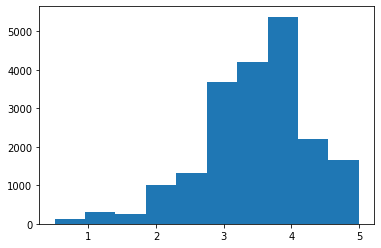

In [ ]:
est = []
for p in predictions:
  for i in p:
    if isinstance(i, float):
      est.append(i)
plt.hist(est)


In [ ]:
len(est)

20142

# Memory Based CF

# Functions

In [ ]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        #mean_user_rating = ratings.mean(axis=1)
        mean_user_rating = ratings.sum(axis=1)/(ratings != 0).sum(axis=1)
        # Use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

# Function to calculate RMSE
def rmse(pred, actual):
    # Ignore zero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(pred, actual))

## User-Based

In [ ]:
import random

def top_n_predictions_user(user_prediction, n=100):
  random_seq = [random.randint(0, len(user_prediction) - 1) for i in range(0, 10)]
  random_user_matrix = np.zeros((len(random_seq), 10))
  for i, j in enumerate(random_seq):
    sorted_prediction = user_prediction[j].argsort()[-10:][::-1]
    random_user_matrix[i] = sorted_prediction

  return random_user_matrix.flatten()

In [ ]:
#USER

kf = sk_KFold(n_splits = n_splits)

user_rmse = np.zeros((n_splits))
user_serendipity = np.zeros((n_splits))
user_time = np.zeros((n_splits))

#for j in range(0, 10):
  #start = timeit.default_timer()  
for i, (train_ind, test_ind) in enumerate(kf.split(data_matrix)):
  # User Similarity Matrix
  user_correlation = 1 - pairwise_distances(data_matrix[train_ind], metric='correlation')
  user_correlation[np.isnan(user_correlation)] = 0
  user_prediction = predict(data_matrix[train_ind], user_correlation, type='user')

  #linear mapping
  user_prediction = np.interp(user_prediction, (user_prediction.min(), user_prediction.max()), (1, 5))
  top_user_predictions = top_n_predictions_user(user_prediction)

  user_rmse[i] = rmse(user_prediction, data_matrix[train_ind])
  user_serendipity[i] = serendipity(baseline, top_user_predictions)

  #stop = timeit.default_timer()
  #user_time[j] = stop - start

(array([ 399., 1508., 5392., 8034., 3579.,  950.,  174.,   30.,   38.,
          38.]),
 array([1.00039452, 1.30989498, 1.61939543, 1.92889589, 2.23839634,
        2.5478968 , 2.85739726, 3.16689771, 3.47639817, 3.78589862,
        4.09539908]),
 <a list of 10 Patch objects>)

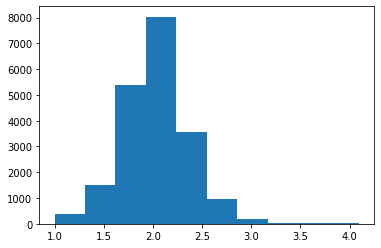

In [ ]:
sample_user_preds = np.random.choice(user_prediction.flatten(), size=len(est), replace=False)
plt.hist(sample_user_preds)

## Item-Based

In [ ]:
#ITEM

item_rmse = np.zeros((n_splits))
item_serendipity = np.zeros((n_splits))
item_time = np.zeros((n_splits))

#for j in range(0, 10):
  #start = timeit.default_timer()  
for i, (train_ind, test_ind) in enumerate(kf.split(data_matrix)):
  # Item similarity Matrix
  item_correlation = 1 - pairwise_distances(data_matrix[train_ind].T, metric='correlation')
  item_correlation[np.isnan(item_correlation)] = 0
  item_prediction = predict(data_matrix[train_ind], item_correlation, type='item')

  #linear mapping
  item_prediction = np.interp(item_prediction, (item_prediction.min(), item_prediction.max()), (1, 5))
  top_item_predictions = top_n_predictions_user(item_prediction)

  item_rmse[i] = rmse(item_prediction, data_matrix[train_ind])
  item_serendipity[i] = serendipity(baseline, top_item_predictions)

  #stop = timeit.default_timer()
  #item_time[j] = stop - start


(array([5.3000e+01, 1.9099e+04, 8.3300e+02, 1.0600e+02, 2.1000e+01,
        1.0000e+01, 7.0000e+00, 5.0000e+00, 6.0000e+00, 2.0000e+00]),
 array([1.70900003, 2.03810002, 2.36720002, 2.69630002, 3.02540002,
        3.35450001, 3.68360001, 4.01270001, 4.34180001, 4.6709    ,
        5.        ]),
 <a list of 10 Patch objects>)

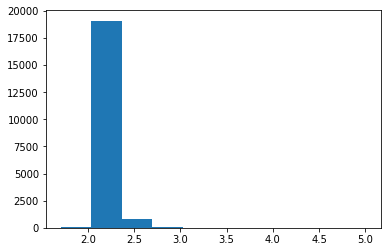

In [ ]:
sample_item_preds = np.random.choice(item_prediction.flatten(), size=len(est), replace=False)
plt.hist(sample_item_preds)

## Calculate mean and confidence interval

In [ ]:
# mean_confidence_interval(item_serendipity, confidence=0.95)
# mean_confidence_interval(user_serendipity, confidence=0.95)
# mean_confidence_interval(svd_serendipity, confidence=0.95)

# mean_confidence_interval(item_rmse, confidence=0.95)
# mean_confidence_interval(user_rmse, confidence=0.95)
# mean_confidence_interval(svd_rmse, confidence=0.95)

mean_confidence_interval(item_time, confidence=0.95)
# mean_confidence_interval(user_time, confidence=0.95)
# mean_confidence_interval(svd_time, confidence=0.95)


(204.72598199559997, 1.6314746569840963)

## Visualisation

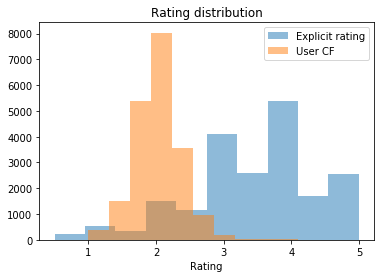

In [ ]:
sample_explicit_preds = np.random.choice(data_matrix[data_matrix != 0], size=len(est), replace=False)
plt.figure(0)
plt.title("Rating distribution")
plt.xlabel("Rating")
plt.hist(sample_explicit_preds, alpha=0.5, label="Explicit rating")
plt.hist(sample_user_preds, alpha = 0.5, label="User CF")
plt.legend(loc="upper right")


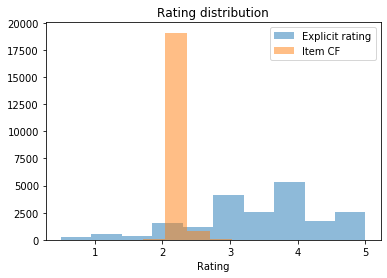

In [ ]:
plt.figure(1)
plt.title("Rating distribution")
plt.xlabel("Rating")
plt.hist(sample_explicit_preds, alpha=0.5, label="Explicit rating")
plt.hist(sample_item_preds, alpha = 0.5, label="Item CF")
plt.legend(loc="upper right")


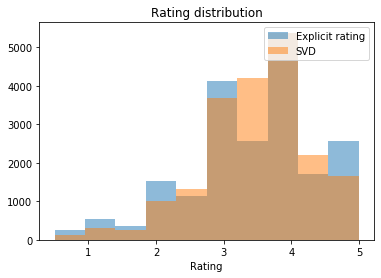

In [ ]:
plt.figure(2)
plt.title("Rating distribution")
plt.xlabel("Rating")
plt.hist(sample_explicit_preds, alpha=0.5, label="Explicit rating")
plt.hist(est, alpha = 0.5, label="SVD")
plt.legend(loc="upper right")